# Calculate entropy of nGrams

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Preliminary definitions.
alphabets_str = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabets = [char for char in alphabets_str]
N = len(alphabets)
assert (N==26)

### Older Codes

In [14]:
count_ngram_freq (['aa', 'ab'],'a')

(3, 4)

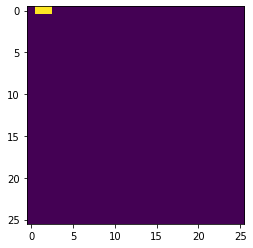

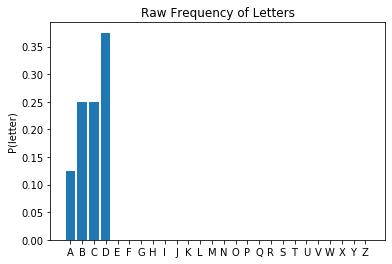

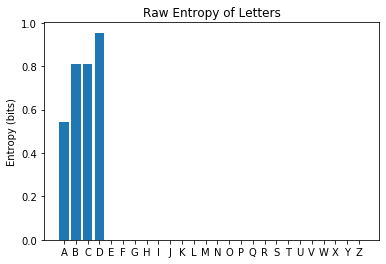

In [3]:
# Calculate counts and entropy of ngram.
# The calculation is based on the total counts.
# (not sensitive to the location or word identity).


# This function gives the number of the specific ngram in a list of words, and the total number
# of grams of the length n in the list of words. - JM
def count_ngram_freq (wordList,ngram):
    # Count the frequency of ngram within the wordList.
    ngram_count = 0 # number of ngrams in a word list.
    ngram_total = 0 # number of possible ngrams.
    for word in wordList:
        for j in range(len(word)-len(ngram)+1):
            curr_ngram = word[j:j+len(ngram)]
            # We could calculate ngram_total by the len(word) and len(ngram),
            # but here is a tedious, brute-force way.
            ngram_total = ngram_total+1 
            if curr_ngram==ngram:
                ngram_count = ngram_count+1
    return ngram_count, ngram_total

assert (2,6)==count_ngram_freq(list(['ABC','BCD']),'B')
assert (1,4)==count_ngram_freq(list(['ABC','BCD']),'AB')
assert (3,6)==count_ngram_freq(list(['ABAB','ABCD']),'AB')

# H_X = p*log2(p) + (1-p)*log2(1-p), where p = probability of nGram.
def H_X (wordList,ngram): # entropy of a particular ngram
    ngram_count,ngram_total = count_ngram_freq(wordList,ngram)
    p = float(ngram_count / ngram_total)
    if (p==0) or (p==1):
        H_X = 0
    else:
        H_X = p*np.log2(p) + (1-p)*np.log2(1-p)
    return -H_X

assert 1.0==H_X(list(['A','B']),'A')
assert H_X(list(['A','B','C','D']),'A') == -0.25*np.log2(0.25) -0.75*(np.log2(0.75))
assert 1.0==H_X(list(['ABC','CAB']),'AB') # AB appears 2 times out of 4 possible bigrams.

def prob_bigrams (wordList,alphabets=alphabets):
    # Calculate probability of a bigram, regardless of its location.
    len_ngram = 2 # 2 for bigram.
    N = len(alphabets)
    # Go through all bigrams with a double loop.
    P_Y = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            bigram = alphabets[i]+alphabets[j]
            gram_count,gram_total = count_ngram_freq(wordList,bigram)
            P_Y[i,j] = gram_count/gram_total

    P_Y = P_Y/np.sum(P_Y)
    return P_Y

P_Y = prob_bigrams(list(['AB','AC']))
assert 0.50 == P_Y[0,1]
assert 0.50 == P_Y[0,2]
plt.imshow(P_Y)
plt.show()

wordList = list(['AB','BC','CD','DD'])
N = len(alphabets)
P_Y = np.zeros(N)
H_Y = np.zeros(N)
for i,lett in enumerate(alphabets):
    lett_count, total = count_ngram_freq(wordList,lett)
    P_Y[i] = float(lett_count)/float(total)   
    H_Y[i] = H_X(wordList,lett) 

plt.bar(range(N),P_Y)
plt.xticks(range(N),labels=alphabets)
plt.ylabel('P(letter)')
plt.title('Raw Frequency of Letters')
plt.show()

plt.bar(range(N),H_Y)
plt.xticks(range(N),labels=alphabets)
plt.ylabel('Entropy (bits)')
plt.title('Raw Entropy of Letters')
plt.show()

Mutual information of two jointly discrete random variables $X$ and $Y$) is calculated as a  double sum:

$$
I(X;Y) = \sum_{x}\sum_{y} P(x,y) \log\left(\frac{P(x,y)}{P(x)P(y)}\right)
$$

In our case, $X$ is a word, so $P(X) = 1/N$, where N is the number of words in the dictionary.  We could incorporate word frequency, but we will see.  $Y$ is an ngram, so $P(Y)$ will have to be estimated by counting the occurance of ngrams.  $P(X,Y)$ will be time-consuming to calculate.  Note for 2-gram (or bigram), there are 26x26 possibilities.

Let us do something a bit more sophisticated (although it turns out that the final result is very similar to the simple calculation of entropy).

Maybe we want to know how many bits of information are there about a word for a given ngram.  Given a particular letter/ngram, how much uncertainty about a word can be lifted?  If the word list is ("AB","BC"), knowing that the word contains letter "A" gives 1 bit of information, where as letter "B" or "D" gives 0 bit of information.  We want to quantify this notion.

We can create a vector $N$ (number of words in the list), which will keep track of whether a particular ngram appears in each word.  Then, $P(Y) = k/N$ = probability of a word with a particular ngram ($Y$) within the list.  $P(X) = 1/N$ = probability of a given word.  Then $P(X,Y)$ denotes the probability of a word and the existence of ngram within the word, so $P(X,Y) = 1/N$, if $X$ is a word with the ngram, and 0, if $X$ does not contain the ngram.  

Therefore, for a particular word, one of the terms in the calculation of mutual information becomes:

$(1/N) \log_{2}\frac{(1/N)}{(1/N)(k/N)} + 0$, if ngram is found, and there would be $k$ such terms, 

or $0 + (1/N) \log_{2}\frac{(1/N)}{(1/N)((N-k)/N)}$, if ngram is not found, and there would be $N-k$ such terms.

In other words, this calculation becomes $- [ P \log_2 P + (1-P) \log_2 (1-P) ]$, where $P = k/N$.  # I added a negative - JM

In [61]:
def find_ngram_in_word (wordList,ngram):
    # Create a vector that indicates whether the ngram is found.
    ngram_found = np.zeros(len(wordList))
    
    for w, word in enumerate(wordList):
        is_found = False
        for j in range(len(word)-len(ngram)+1):
            curr_ngram = word[j:j+len(ngram)]
            if curr_ngram==ngram:
                is_found = True
        if is_found:
            ngram_found[w] = 1.0
    return ngram_found

np.testing.assert_array_equal(find_ngram_in_word(list(["ABC","BCD"]),"AB"),np.array([1,0]))
np.testing.assert_array_equal(find_ngram_in_word(list(["ABC","BCD"]),"BC"),np.array([1,1]))
np.testing.assert_array_equal(find_ngram_in_word(list(["ABC","BCD"]),"B"),np.array([1,1]))

def calc_mutinfo_ngram (wordList,ngram):
    ngram_found = find_ngram_in_word(wordList,ngram)
    k = np.sum(ngram_found)
    N = len(wordList)
    P = float(k)/float(N)
    # print(k, ',', N)  # - JM
    mi = 0
    if (P==0.0) or (P==1.0):
        mi = 0
    else:
        mi = P*np.log2(P) + (1.0-P)*np.log2(1.0-P)
    return -mi

# assert (calc_mutinfo_ngram(list(["ABC","BCD"]),"E")==0)
# assert (calc_mutinfo_ngram(list(["ABC","BCD"]),"BC")==0)
# assert (calc_mutinfo_ngram(list(["ABC","BCD"]),"AB")==1)

In [62]:
calc_mutinfo_ngram(list(['CAT', 'CAB', 'MAP', 'CAR']),'AP')

0.8112781244591328

In [63]:
calc_mutinfo_ngram(list(['CAT', 'CAB', 'MAP', 'CAR']),'CA')

0.8112781244591328

In [7]:
# Analyze 2-grams (bigrams)

# Calculate mutual info of bigrams at different locations from a word list.
def mutinfo_bigram_loc (wordList,alphabets=alphabets,loc=0):
    # Input arguement <loc> determines the location of the bigram.
    # loc=0: consider bigrams at the beginning of the word.
    # loc=1: consider bigrams starting at the second character or each word.
    N = len(alphabets)
    len_ngram = 2 # 2 for bigrams.
    
    # Now calculate mutual info, by summing over X and Y.
    P_X = 1/len(wordList)
    P_Y = np.zeros((N,N))
    P_XY = np.zeros((len(wordList),N,N))

    for w, word in enumerate(wordList):
        for i in range(N):
            for j in range(N):
                bigram = alphabets[i]+alphabets[j]
                if word[loc:loc+len_ngram]==bigram:
                    P_Y[i,j] = P_Y[i,j]+1  # P_Y will give the number of words for which the 
                                           # bigram shows up in the 'loc' position - JM
                    P_XY[w,i,j] = P_XY[w,i,j]+1  # P_XY will either be 1 if the word 'word' 
                                                 # contains the bigram in the 'loc' position - JM
    P_Y = P_Y/np.sum(P_Y)
    P_XY = P_XY/np.sum(P_XY)

    mutinfo = 0
    for w in range(len(wordList)):
        for i in range(N):
            for j in range(N):
                if (P_XY[w,i,j]>0) & (P_Y[i,j]>0): # otherwise 0.
                    prob_ratio = P_XY[w,i,j]/(P_Y[i,j]*P_X)
                    mutinfo = mutinfo + P_XY[w,i,j]*np.log2(prob_ratio)
    return mutinfo

wordList = list(['AABC','AABD','AACC','AACD'])
mi0 = mutinfo_bigram_loc(wordList,loc=0)  
mi1 = mutinfo_bigram_loc(wordList,loc=1)
mi2 = mutinfo_bigram_loc(wordList,loc=2)  
assert mi0==0  # knowing the first bigram tells you nothing - JM
assert mi1==1
assert mi2==2  # knowing the third bigram gives you two bits - JM

Do some statistics on letter over a word list.
For example, what is the overall distribution of each letter.
What is the entropy, and what is the mutual information between letter and word, where $P(word) = 1/N(words)$ and $P(letter) = k/N(words) = $ probability of finding a particular letter in a word ($k$ = number of words with letter).

## Work with real dictionary of words.

In [57]:
# Load wordList from a text file.
filename = 'words6.txt'
f = open(filename, 'rt') 
lines = f.readlines() 
wordList = [w.replace('\n','') for w in lines]  # .strip() would work too - JM

1963.0 , 4622
618.0 , 4622
983.0 , 4622
1081.0 , 4622
2910.0 , 4622
423.0 , 4622
707.0 , 4622
675.0 , 4622
1657.0 , 4622
79.0 , 4622
306.0 , 4622
1473.0 , 4622
784.0 , 4622
1463.0 , 4622
1397.0 , 4622
772.0 , 4622
50.0 , 4622
2044.0 , 4622
1341.0 , 4622
1513.0 , 4622
1043.0 , 4622
291.0 , 4622
331.0 , 4622
94.0 , 4622
740.0 , 4622
89.0 , 4622


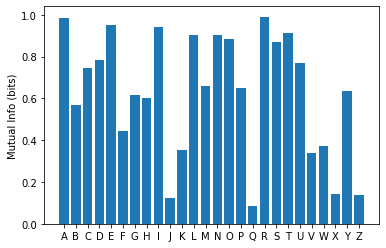

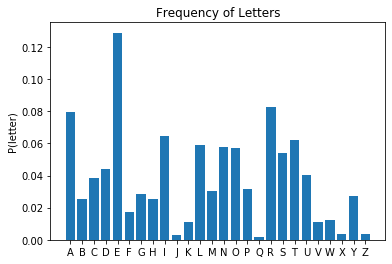

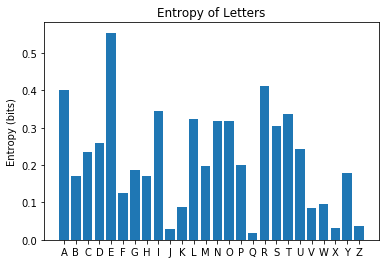

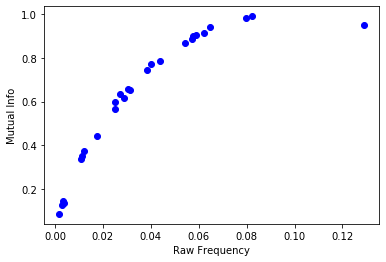

In [58]:
# Analyze each letter.
N = len(alphabets)
P_Y = np.zeros(N)
H_Y = np.zeros(N)
mi_lett = np.zeros(N)

for i,lett in enumerate(alphabets):
    lett_count, total = count_ngram_freq(wordList,lett)  # Has multiple counts per word! - JM
    P_Y[i] = float(lett_count)/float(total)  # I think this doesn't agree with the earlier def.
                                             # of P_Y, because it gives a count of > 1 when an 
                                             # n_gram shows up more than once in a word, better
                                             # to use find n_gram_in_word function? - JM
    H_Y[i] = H_X(wordList,lett) 
    mi_lett[i] = calc_mutinfo_ngram(wordList,lett)

plt.bar(range(N),mi_lett)
plt.xticks(range(N),labels=alphabets)
plt.ylabel('Mutual Info (bits)')
plt.show()

plt.bar(range(N),P_Y)
plt.xticks(range(N),labels=alphabets)
plt.ylabel('P(letter)')
plt.title('Frequency of Letters')
plt.show()

plt.bar(range(N),H_Y)
plt.xticks(range(N),labels=alphabets)
plt.ylabel('Entropy (bits)')
plt.title('Entropy of Letters')
plt.show()

# Observation: MI may be a better measure.
# For example, "e" does not dominate MI as much.
plt.plot(P_Y,mi_lett,'o',color='blue')
plt.ylabel('Mutual Info')
plt.xlabel('Raw Frequency')
plt.show()

In [75]:
idx = np.argsort(-mi_bigram,axis=None)
print(idx[:8])
np.unravel_index(290,(26,26))

[121 290 221 107 446 498  17 117]


(11, 4)

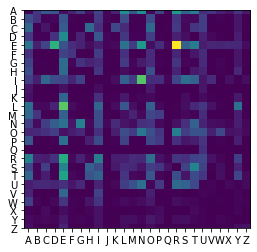

ER: 0.62252
LE: 0.46404
IN: 0.45709
ED: 0.40312
RE: 0.38459
TE: 0.36143
AR: 0.34077
EN: 0.33908
AL: 0.30530
AN: 0.30530


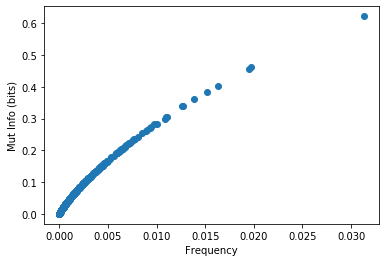

In [66]:
mi_bigram = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        bigram = alphabets[i]+alphabets[j]
        mi_bigram[i,j] = calc_mutinfo_ngram(wordList,bigram)

plt.imshow(mi_bigram)
plt.xticks(range(N),labels=alphabets)
plt.yticks(range(N),labels=alphabets)
plt.show()

#m_ravel = np.ravel(mi_bigram)
idx = np.argsort(-mi_bigram,axis=None)
topN = 10  # - JM
for k in idx[:topN]:
    i,j = np.unravel_index(k,(26,26))  # index number to row column, (column is remainder) - JM
    bigram = alphabets[i]+alphabets[j]
    print('%s: %6.5f'%(bigram,mi_bigram[i,j]))

# Raw frequency of bigrams.
P_Y = prob_bigrams(wordList)  # Uses 'raw frequency' def of P_Y
plt.plot(np.ravel(P_Y),np.ravel(mi_bigram),'o')
plt.xlabel('Frequency')
plt.ylabel('Mut Info (bits)')
plt.show()

# np.savetxt('mutinfo_bigram.csv', mi_bigram, delimiter=',')

In [8]:
mi = np.zeros(5)
for i in range(5):
    mi[i] = mutinfo_bigram_loc(wordList,loc=i)
    print('MI for loc=%d: %6.5f'%(i,mi[i]))


MI for loc=0: 7.08097
MI for loc=1: 7.34726
MI for loc=2: 7.84740
MI for loc=3: 7.22544
MI for loc=4: 6.20638


The starting and ending bigrams of six-letter words are perhaps not very unique/diverse and are formulaic and repetitive? And yet they were the most informative to subjects. - JM

In [78]:
# Calculate mutual information of bigrams at different locations.
loc = 0
new_wordList = list()
for w, word in enumerate(wordList):
    new_wordList.append(word[loc:loc+2])
    
mi_bgram = 
mi = calc_mutinfo_ngram(new_wordList,)

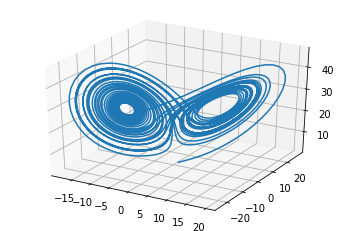